In [34]:
import pycuda.driver as cuda
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import numpy as np
import cv2
from pycuda.compiler import SourceModule
import matplotlib.pyplot as plt
import time

In [35]:
filepath = "/mnt/d/CUDA/day9/edgeDetection.ptx"

module = cuda.module_from_file(filepath)
rgb_to_grayscale = module.get_function('RGB2Grayscale')
image_blur = module.get_function('imageBlur')
grayscale_to_float = module.get_function('intToFloat')
edge_detection_laplacian = module.get_function('edgeDetectionLaplacianConv2D')

In [36]:
input_image = cv2.imread('/mnt/d/CUDA/day9/image.jpg')
height, width, _  = input_image.shape

rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

In [37]:
rgb_array = rgb.flatten()
gray_array = np.empty((height, width), dtype=np.uint8)
blurred_array = np.empty((height, width), dtype=np.uint8)
blurred_float_array = np.empty((height, width), dtype=np.float32)
edge_detected_array = np.empty((height, width), dtype=np.float32)

In [38]:
rgb_gpu = cuda.mem_alloc(rgb_array.nbytes)
gray_gpu = cuda.mem_alloc(gray_array.nbytes)
blurred_gpu = cuda.mem_alloc(blurred_array.nbytes)
blurred_float_gpu = cuda.mem_alloc(blurred_float_array.nbytes)
edge_detected_gpu = cuda.mem_alloc(edge_detected_array.nbytes)

In [39]:
cuda.memcpy_htod(rgb_gpu, rgb_array)

In [40]:
n_threads = (32, 32, 1)
block_x = (n_threads[0] + width - 1) // n_threads[0]
block_y = (n_threads[1] + height - 1) // n_threads[1]
grid = (block_x, block_y, 1)

In [41]:
rgb_to_grayscale(rgb_gpu, gray_gpu, np.int32(width), np.int32(height), block=n_threads, grid=grid)

In [42]:
image_blur(gray_gpu, blurred_gpu, np.int32(width), np.int32(height), block=n_threads, grid=grid)

In [43]:
grayscale_to_float(gray_gpu, blurred_float_gpu, np.int32(width), np.int32(height), block=n_threads, grid=grid)

In [44]:
laplacian_filter = np.array([0, 1, 0, 1, -4, 1, 0, 1, 0], dtype=np.float32).flatten()
laplacian_filter_gpu = cuda.mem_alloc(laplacian_filter.nbytes)
cuda.memcpy_htod(laplacian_filter_gpu, laplacian_filter)

In [45]:
edge_detection_laplacian(blurred_float_gpu, edge_detected_gpu, laplacian_filter_gpu, np.int32(width), np.int32(height), block=n_threads, grid=grid)

In [46]:
cuda.memcpy_dtoh(gray_array, gray_gpu)
cuda.memcpy_dtoh(blurred_array, blurred_gpu)
cuda.memcpy_dtoh(blurred_float_array, blurred_float_gpu)
cuda.memcpy_dtoh(edge_detected_array, edge_detected_gpu)

In [47]:
edge_detected_normalized = np.clip(edge_detected_array, 0, 255).astype(np.uint8)

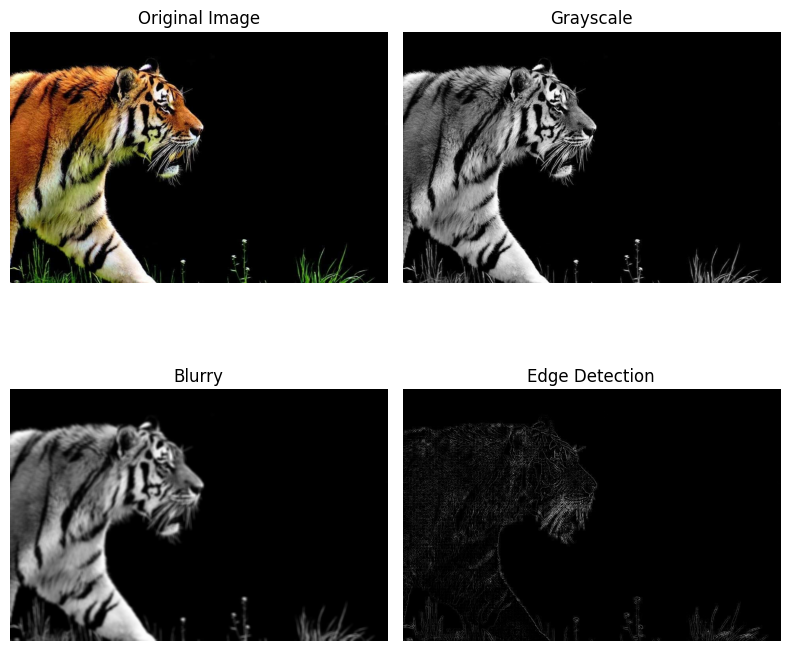

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].imshow(rgb)
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

axs[0, 1].imshow(gray_array, cmap='gray')
axs[0, 1].set_title('Grayscale')
axs[0, 1].axis('off')

axs[1, 0].imshow(blurred_array, cmap='gray')
axs[1, 0].set_title('Blurry')
axs[1, 0].axis('off')

axs[1, 1].imshow(edge_detected_normalized, cmap='gray')
axs[1, 1].set_title('Edge Detection')
axs[1, 1].axis('off')

plt.tight_layout()
plt.savefig('/mnt/d/CUDA/day9/output_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [49]:
cv2.imwrite('/mnt/d/CUDA/day9/gray_image.jpg', gray_array)
cv2.imwrite('/mnt/d/CUDA/day9/blurred_image.jpg', blurred_array)
cv2.imwrite('/mnt/d/CUDA/day9/edge_detected_image.jpg', edge_detected_normalized)

True